# INM701 Coursework
### Aaron Mir (Student Number: 160001207)

In this coursework, you are expected to demonstrate what you have learned in the module by applying artificial intelligence techniques as covered in the module to a dataset and domain of your choice. This will include some or all of:

    • Define the domain and dataset(s) (you are free to choose the domain and the dataset that you want to investigate).

    • Define  questions and analysis tasks (a brief overview  of  the  domain, analytical questions that are being asked, a list of your objectives and the 
    expected output(s)of your analysis)
    
    • Perform an initial investigation of the dataset and the characteristics of the data. Develop a viable plan: which data processing steps you will need to
    perform, how you will transform the data to make it useable, which artificial intelligence techniques you can potentially use and what sorts of potential
    observations these can lead to.

    • Perform the analysis.  Get the data ready for analysis, carry out your analysis/modelling as needed, validate your results and communicate observations, 
    iterating through this process. Analytical operations can include data processing to an extent that is needed (not all datasets are messy) to prepare a useful and
    robust dataset to work within, and data derivation (such as feature engineering).

    • Split your dataset (train/validate/test, somedatasets come pre-split). If you have a holdout test set then you most likely don’t want to use this until the near 
    the end of your work.

    • You might establish a baseline result first, computing metrics on training and validation sets,  analyse  errors, work  on  succeeding iterations, and 
    alternative models. (If initial metrics are amazing and there are no errors is the problem too easy?)

    • Be  close to your data  (visualise  the  dataset,  collect  summary  statistics,  look  at  errors, analyse how different parameters affect performance, try 
    out different model variants).


## Classification of Atrial Fibrillation using a 1D Convolutional Neural Network and kNN
Goal: Use the Paroxysmal Atrial Fibrillation Prediction Challenge Database to build a model that can predict onset of Atrial Fibrillation (AF) from an Electrocardiogram (ECG) signal. This database contains a training set (with 50 30-minute two-lead ECGs of patients with Normal Sinus Rhythm (NSR/no signs of AF) and 50 30-minute two-lead ECGs of patients with Paroxysmal AF) and a testing set. The labels of the testing set are not known so in order to test the model, the training set will be split into training and testing sets. 

Extra goal: Use model on other databases


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import os
import scipy
from scipy.signal import filtfilt
from scipy import stats
import itertools
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import keras
import tensorflow.keras.utils
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPool1D, Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.python.client import device_lib

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"Tesorflow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
Tesorflow Version: 2.3.0
Keras Version: 2.4.0
Sklearn Version: 0.23.1


In [3]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data Preprocessing and Segmentation

In [4]:
classification = ['NSR', 'AF']
train_folder =  'data/Train'          # data in csv format
numpy_data = 'data/Numpy_Data'        # will contain X_train and y_train data after conversion to np file 

In [5]:
def bandpass_filter(X): # Function to filter the signal between 0.05 and 40Hz to remove baseline wander, motion artifacts, line frequency, respiratory artifacts etc.
    fs = 128.0
    highpass_cutoff = 1.0
    lowpass_cutoff = 40.0

    nyq = 0.5 *fs
    low = highpass_cutoff / nyq
    high = lowpass_cutoff / nyq
    order = 1

    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    x_bp = scipy.signal.filtfilt(b, a, X, axis=0)
    return x_bp

In [6]:
# Each ECG file has 230400 data points and two-leads so two columns per lead and 100 ECG files in total but we want to segment these in order to feed more easily into the model
def load_label_segment(location): 
    X = []
    y = []
    for i in classification:                                                            # iterate through each type of classification
        for data in os.listdir(location + i):
            df = pd.read_csv(location + i + '\\' + data, names=["ECG1", "ECG2"])        # load the CSV for each file per each classification
            #df.drop(['ECG2'], axis=1, inplace=True)                                     # drop the second ECG lead
            split = np.array_split(df, 30)                                               # splitting the data into 5 minute lengths to decrease number of convolutions and increase speed 60 for 30 sec, 30 for 1 min, 6 for 5 min
            for array in split:
                X.append(np.array(bandpass_filter(array)))                              # apply the filter to the ECGs
                if i == 'NSR':                                                          # label data accordingly
                    y.append(0)
                if i == 'AF':
                    y.append(1)    
    return np.array(X), np.expand_dims(np.array(y), axis=1)    

In [21]:
# Load the training data
X_train, y_train = load_label_segment(train_folder)
print(X_train.shape, y_train.shape)

(3000, 7680, 2) (3000, 1)


In [110]:
np.save('data/Numpy_Data/X_train.npy', X_train) # saving the training data as np files for easy access
np.save('data/Numpy_Data/y_train.npy', y_train)

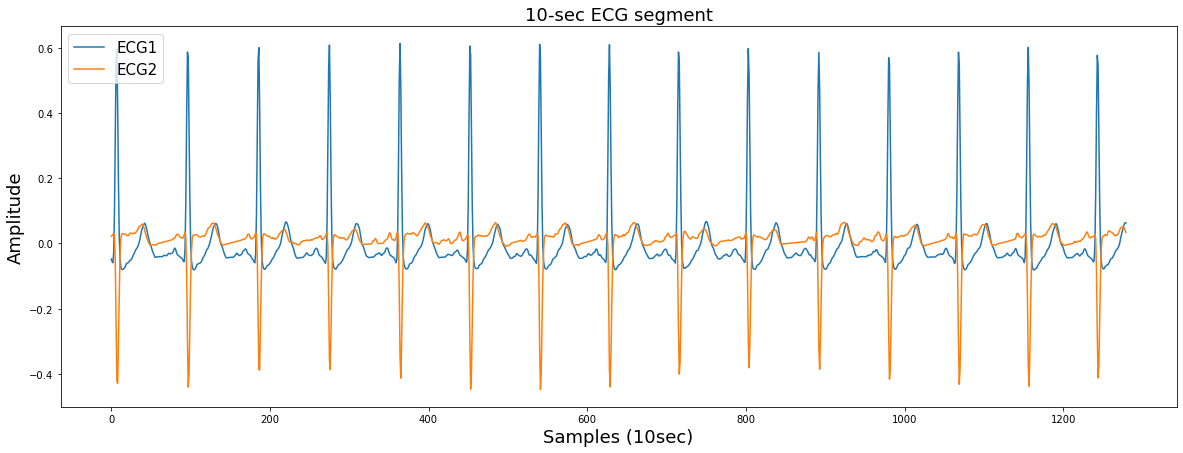

In [181]:
plt.figure(figsize=(20, 7))
plt.plot(X_train[0][1000:2280]) # 
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper left", prop={'size': 15})
#fig.savefig('30-Min Normal ECG.jpg')
plt.show()

## 1D Convolutional Neural Network Models
### GPU is available for training the model, IT IS RECOMMENDED TO USE GPU FOR THE MODELS
For the evaluation of the models, we split our data into training, testing and validation sets as seen below. The publicly available dataset is fairly which is why we segment the data. As a result of this, the testing and validation sets are fairly small but I believe it is important to include a validation set in order to validate the training and see if it is overfitting, underfitting etc.

In [25]:
device_lib.list_local_devices(); 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=30) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=30)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=30) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=30)

In [23]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(1080, 7680, 2) (1080, 1)
(1200, 7680, 2) (1200, 1)
(720, 7680, 2) (720, 1)


## Configuration - WORKS WELL - IS SMALL AND FAST - USES 5 MINUTE ECG SEGMENTS AS INPUT

In [123]:
# input, convolutional, subsampling(maxpool), fully connected and output
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=32, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(38400, 2)))
model.add(MaxPool1D(pool_size=32))
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=64))
model.add(Flatten())
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 38400, 64)         4160      
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 1200, 64)          0         
_________________________________________________________________
dense_64 (Dense)             (None, 1200, 32)          2080      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 18, 32)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 577       
Total params: 6,817
Trainable params: 6,817
Non-trainable params: 0
___________________________________________________

In [124]:
optimizer = keras.optimizers.SGD(lr=0.009, momentum=0.9) # 0.09, 0.9 #lr=0.005, momentum=0.9 #lr=0.001, momentum=0.9
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=80, validation_data=(X_val,y_val))

Epoch 1/75
6/6 [==============================] - 1s 188ms/step - loss: 0.6923 - accuracy: 0.4974 - val_loss: 0.6908 - val_accuracy: 0.5312
Epoch 2/75
6/6 [==============================] - 1s 158ms/step - loss: 0.6897 - accuracy: 0.5365 - val_loss: 0.6859 - val_accuracy: 0.5417
Epoch 3/75
6/6 [==============================] - 1s 140ms/step - loss: 0.6845 - accuracy: 0.5677 - val_loss: 0.6813 - val_accuracy: 0.5521
Epoch 4/75
6/6 [==============================] - 1s 140ms/step - loss: 0.6794 - accuracy: 0.5781 - val_loss: 0.6752 - val_accuracy: 0.6146
Epoch 5/75
6/6 [==============================] - 1s 138ms/step - loss: 0.6728 - accuracy: 0.6042 - val_loss: 0.6682 - val_accuracy: 0.6354
Epoch 6/75
6/6 [==============================] - 1s 139ms/step - loss: 0.6640 - accuracy: 0.6302 - val_loss: 0.6593 - val_accuracy: 0.6667
Epoch 7/75
6/6 [==============================] - 1s 140ms/step - loss: 0.6540 - accuracy: 0.6589 - val_loss: 0.6465 - val_accuracy: 0.6771
Epoch 8/75
6/6 [====

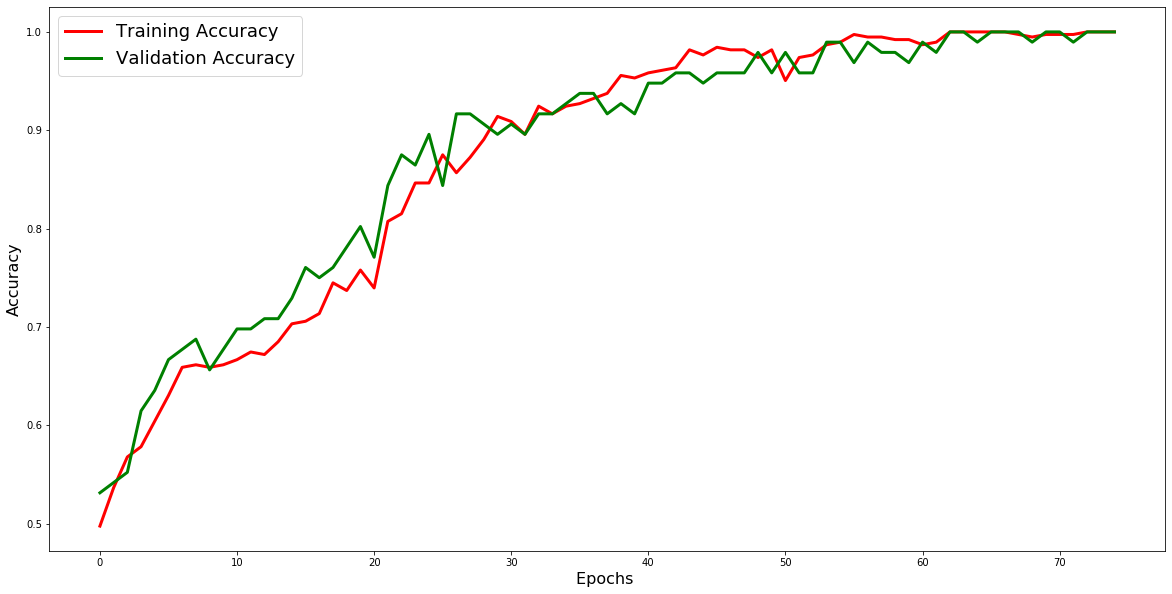

In [125]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

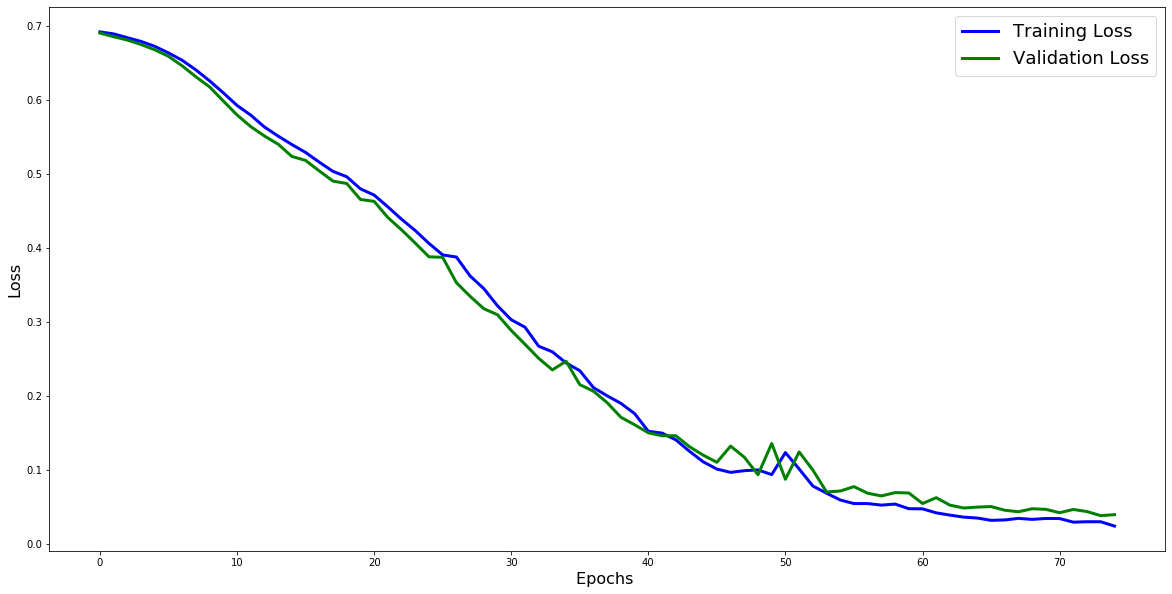

In [126]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'], 'b', linewidth=3.0, label='Training Loss')
plt.plot(history.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.legend(fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [127]:
y_pred = model.predict(x=X_test, batch_size=64)

In [128]:
y_pred = np.round(y_pred)
print(y_pred.shape)

(120, 1)


In [129]:
np.count_nonzero(y_pred == 1)

60

In [186]:
for i in range(len(20)):
	print("Predicted=%s, Actual=%s" % (y_pred[i], y_test[i]))

Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
P

In [131]:
accuracy = Accuracy()
accuracy.update_state(y_test, y_pred)
accuracy.result().numpy()

0.9916667

In [132]:
calculated_accuracy = sum(y_pred == y_test)/len(y_pred)
print(calculated_accuracy)

[0.99166667]


In [133]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

Confusion matrix, without normalization
[[60  1]
 [ 0 59]]


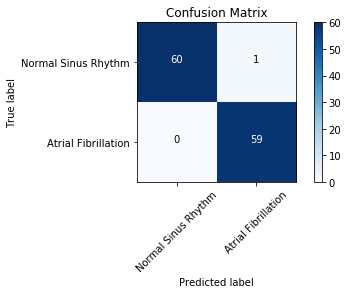

In [135]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [ ]:
model_path = os.path.join('models', 'CNN2-Small')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

## Another Configuration - ONLY WORKS WELL WITH 1 MINUTE ECG SEGMENTS, NOT 5 LIKE THE OTHER MODEL - ALSO REQUIRES MORE PROCESSING POWER 

In [28]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(7680, 2))) # Conv layer taking 1 minute segments input 7680
model.add(BatchNormalization())                                                                                                       # Adding normalisation
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                        # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=64, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                        # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.5))                                                                                                               # Dropout, prevents overfitting (50%)
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.5))                                                                                                               # Dropout (50%)
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(MaxPool1D(pool_size=2))                                                                                                     # Subsampling layer
model.add(Dropout(0.5))                                                                                                               # Dropout (50%)
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))                       # Conv layer
model.add(Flatten())                                                                                                                  # Flatten
model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))                                                           # FC Layer, 128 neurons
model.add(Dropout(0.5))                                                                                                               # Dropout (50%)
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))                                                            # FC layer, 32 neurons
model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))                                                          # Output layer, binary classification
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 7680, 32)          352       
_________________________________________________________________
batch_normalization_4 (Batch (None, 7680, 32)          128       
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 3840, 32)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 3840, 32)          5152      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 1920, 32)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1920, 64)          10304     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 960, 64)          

## TRYING WITH SGD OPTIMIZER - Pretty Good Performance

In [23]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
history3 = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
30/30 [==============================] - 3s 87ms/step - loss: 0.7716 - accuracy: 0.4896 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 2/100
30/30 [==============================] - 2s 77ms/step - loss: 0.6984 - accuracy: 0.4906 - val_loss: 0.6932 - val_accuracy: 0.4833
Epoch 3/100
30/30 [==============================] - 2s 76ms/step - loss: 0.6945 - accuracy: 0.5167 - val_loss: 0.6932 - val_accuracy: 0.4833
Epoch 4/100
30/30 [==============================] - 2s 76ms/step - loss: 0.6962 - accuracy: 0.5125 - val_loss: 0.6933 - val_accuracy: 0.4833
Epoch 5/100
30/30 [==============================] - 2s 76ms/step - loss: 0.6921 - accuracy: 0.5031 - val_loss: 0.6934 - val_accuracy: 0.4833
Epoch 6/100
30/30 [==============================] - 2s 77ms/step - loss: 0.6950 - accuracy: 0.5104 - val_loss: 0.6936 - val_accuracy: 0.4833
Epoch 7/100
30/30 [==============================] - 2s 77ms/step - loss: 0.6923 - accuracy: 0.5229 - val_loss: 0.6935 - val_accuracy: 0.4833
Epoch 

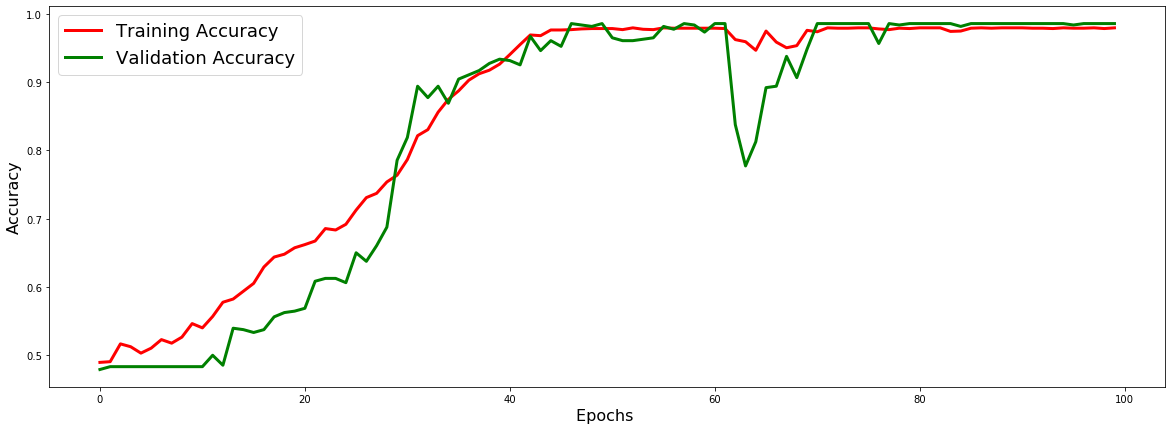

In [25]:
plt.figure(figsize=(20, 7))
plt.plot(history3.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

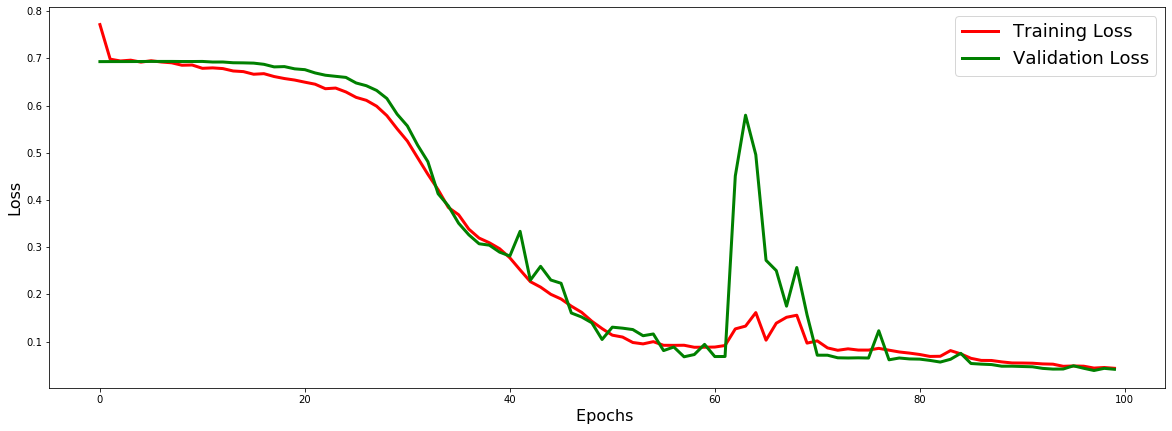

In [26]:
plt.figure(figsize=(20, 7))
plt.plot(history3.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history3.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

## TRYING ADAM 0.4/0.4 test/validation size

In [29]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
history4 = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val)) 

Epoch 1/50
34/34 [==============================] - 2s 59ms/step - loss: 0.7690 - accuracy: 0.4870 - val_loss: 0.6931 - val_accuracy: 0.5222
Epoch 2/50
34/34 [==============================] - 2s 48ms/step - loss: 0.7166 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5194
Epoch 3/50
34/34 [==============================] - 2s 49ms/step - loss: 0.7025 - accuracy: 0.4972 - val_loss: 0.6930 - val_accuracy: 0.5514
Epoch 4/50
34/34 [==============================] - 2s 49ms/step - loss: 0.7072 - accuracy: 0.4787 - val_loss: 0.6930 - val_accuracy: 0.5736
Epoch 5/50
34/34 [==============================] - 2s 48ms/step - loss: 0.6960 - accuracy: 0.5111 - val_loss: 0.6929 - val_accuracy: 0.5431
Epoch 6/50
34/34 [==============================] - 2s 51ms/step - loss: 0.6947 - accuracy: 0.5093 - val_loss: 0.6927 - val_accuracy: 0.5667
Epoch 7/50
34/34 [==============================] - 2s 47ms/step - loss: 0.6901 - accuracy: 0.5120 - val_loss: 0.6922 - val_accuracy: 0.5736
Epoch 8/50
34

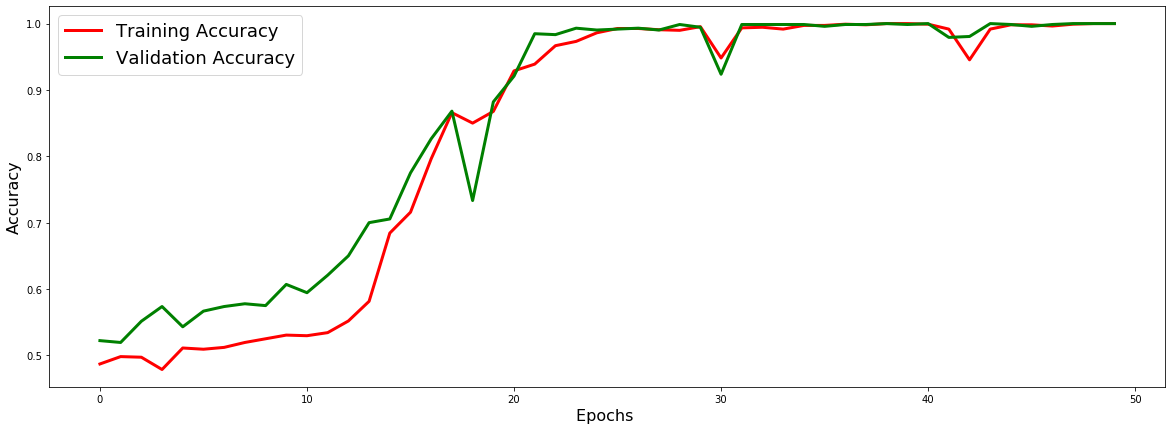

In [30]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], 'g', linewidth=3.0, label='Validation Accuracy')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=18)
plt.show()

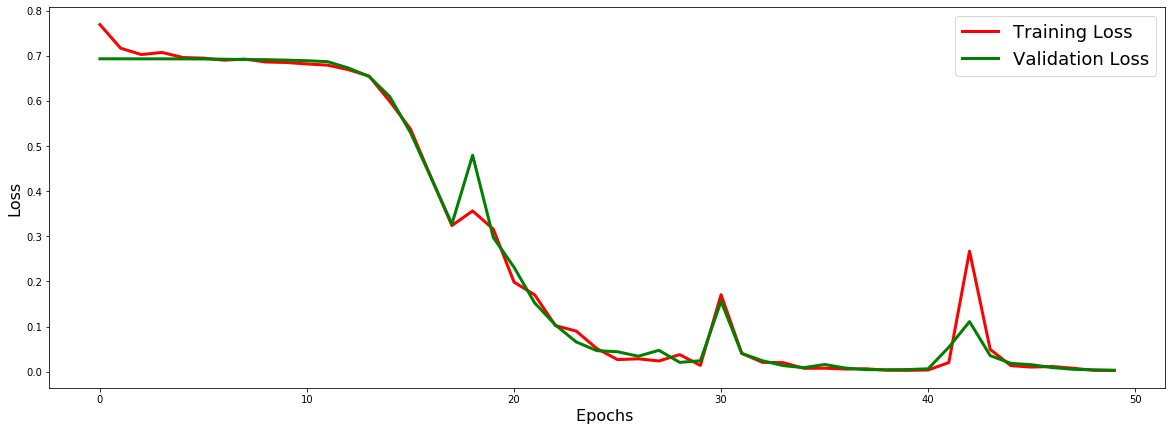

In [31]:
plt.figure(figsize=(20, 7))
plt.plot(history4.history['loss'], 'r', linewidth=3.0, label='Training Loss')
plt.plot(history4.history['val_loss'], 'g', linewidth=3.0, label='Validation Loss')
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=18)
plt.show()

In [32]:
y_pred = model.predict(x=X_test, batch_size=32)

In [33]:
y_pred = np.round(y_pred)

In [34]:
np.count_nonzero(y_pred == 0)

596

In [42]:
for i in range(20):
	print("Predicted=%s, Actual=%s" % (y_pred[i], y_test[i]))

Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]
Predicted=[1.], Actual=[1]
Predicted=[0.], Actual=[0]


In [38]:
accuracy = Accuracy()
accuracy.update_state(y_test, y_pred)
accuracy.result().numpy()

0.99916667

In [39]:
calculated_accuracy = sum(y_pred == y_test)/len(y_pred)
print(calculated_accuracy)

[0.99916667]


In [40]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

Confusion matrix, without normalization
[[596   1]
 [  0 603]]


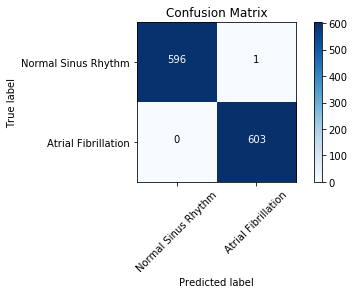

In [41]:
cm_plot_labels = ['Normal Sinus Rhythm', 'Atrial Fibrillation']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [121]:
model_path = os.path.join('models', 'CNN1')
model.save(model_path)
print('Saved trained model at %s ' % model_path)

INFO:tensorflow:Assets written to: models\CNN1\assets
Saved trained model at models\CNN1 


## Extra Trees Classifier (Randomised Decision Trees)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=30)

In [153]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(480, 38400, 2) (480, 1)
(120, 38400, 2) (120, 1)


In [154]:
n_samples_train, n_x_train, n_y_train = X_train.shape

In [155]:
X_train_2D = X_train.reshape((n_samples_train,n_x_train*n_y_train))
print(X_train_2D.shape)

(480, 76800)


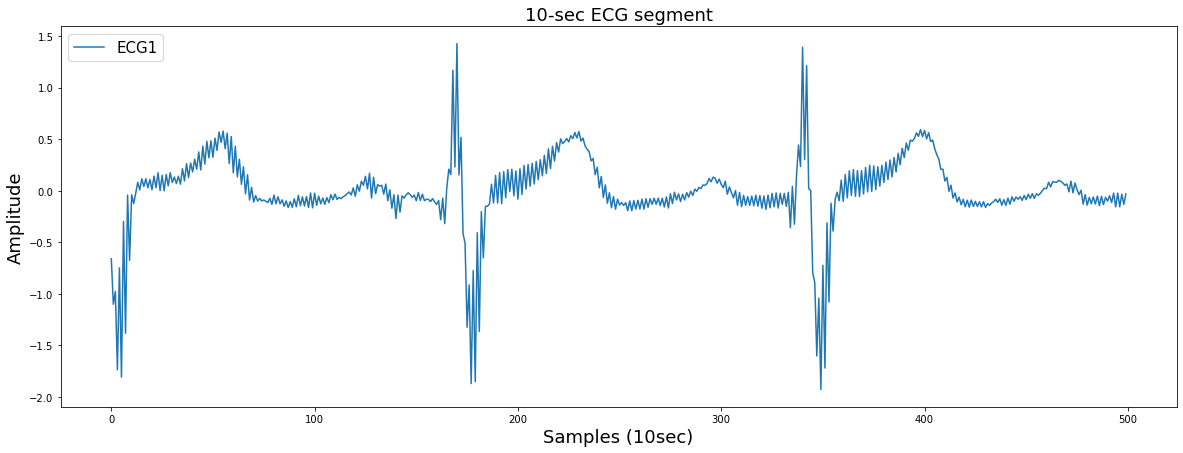

In [179]:
plt.figure(figsize=(20, 7))
plt.plot(d2_train_dataset[1][1000:1500]) # 
plt.xlabel('Samples (10sec)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.title('10-sec ECG segment', fontsize=18)
plt.gca().legend(('ECG1','ECG2'), loc="upper left", prop={'size': 15})
#fig.savefig('30-Min Normal ECG.jpg')
plt.show()

In [160]:
extratree = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=30)

In [163]:
extratree.fit(X_train_2D, y_train)

ExtraTreesClassifier(random_state=30)

In [165]:
n_samples_test, n_x_test, n_y_test = X_test.shape

In [166]:
X_test_2D = X_test.reshape(( n_samples_test, n_x_test*n_y_test ))

In [167]:
print(X_test_2D.shape)

(120, 76800)


In [177]:
y_test[3]

array([1])

In [174]:
extratree.predict(X_test_2D)

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0])

In [169]:
acc_extra_tree = extratree.score(d2_test_dataset, y_test)
print(acc_extra_tree)

0.7333333333333333
